In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

# **Overview**

### **The goal of this project is to detect blindness before it happens, organized by APTOS, data taken from Aravind Eye Hospitals, India. In this synchronous Kernels-only competition, I'm building a machine learning model to speed up disease detection. I’ll be working with thousands of images collected in rural areas to help identify diabetic retinopathy automatically.**

# **Motivation**

### **Diabetic retinopathy (DR) is one of the leading causes of vision loss. The World Health Organization reports that more than 300 million people worldwide have diabetes (Wong et al. 2016). In 2019, the global prevalence of DR among individuals with diabetes was at more than 25% (Thomas et al. 2019). The prevalence has been rising rapidly in developing countries.**

### **Early detection and treatment are crucial steps towards preventing DR. The screening procedure requires a trained clinical expert to examine the fundus photographs of the patient's retina. This creates delays in diagnosis and treatment. This is especially relevant for developing countries, which often lack qualified medical staff to perform the diagnosis. Automated detection of DR can speed up the efficiency and coverage of the screening programs.**

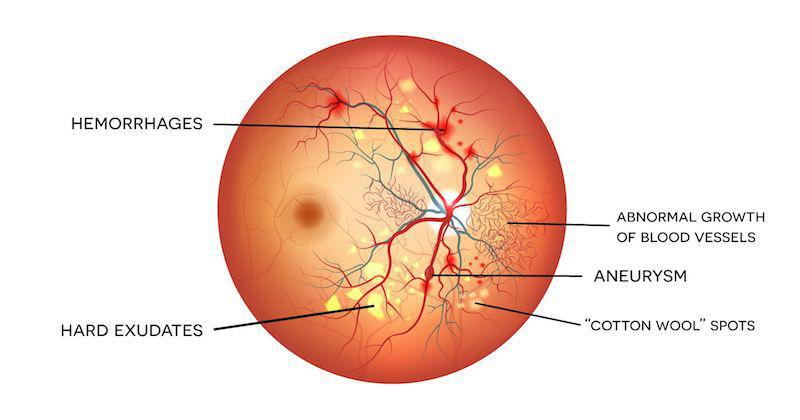

### The images are labeled by a clinical expert. The integer labels indicate the severity of DR on a scale from 0 to 4, where 0 indicates no disease and 5 is the proliferative stage of DR.

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

In [2]:
# import libraries
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score,classification_report

import tensorflow as tf
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input


# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(0)
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

### **Load Data**

In [3]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [4]:
x = train_df['id_code']
y = train_df['diagnosis']

In [5]:
print('Number of train samples: ', train_df.shape[0])
print('Number of test samples: ', test_df.shape[0])
display(train_df.head())

Number of train samples:  3662
Number of test samples:  1928


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

## **Profile Report**

In [6]:
# ! pip install pandas-profiling

In [7]:
import pandas_profiling
pandas_profiling.ProfileReport(train_df)

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

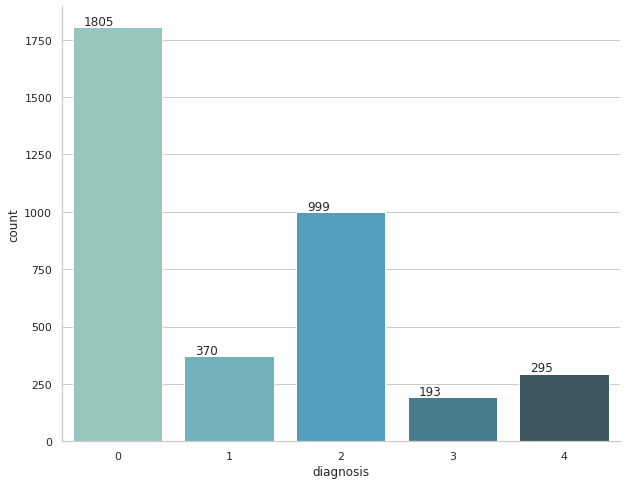

In [8]:
# plot categorical graph based on diagnosis class (0 = No DR, 1 – Mild , 2 – Moderate, 3 – Severe, 4 – Proliferative DR)

f, ax = plt.subplots(figsize=(10, 8))
ax = sns.countplot(x="diagnosis", data=train_df, palette="GnBu_d")
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))
sns.despine()
plt.show()


# **Data Preparation**

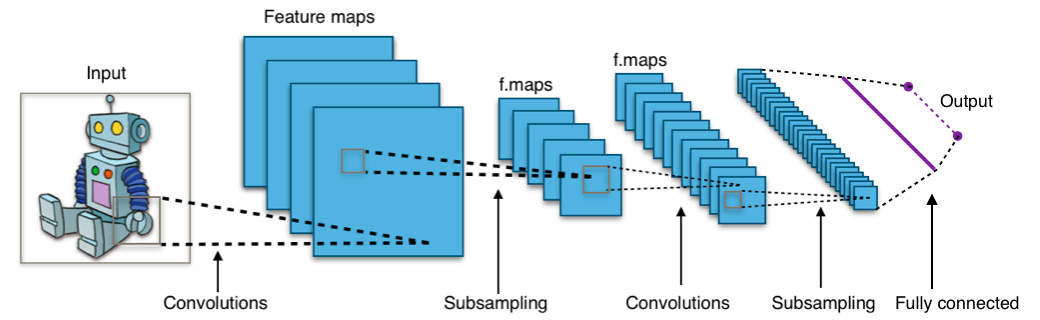

## Data preparation is a very important step that is frequently underestimated. The quality of the input data has a strong impact on the resulting performance of the developed machine learning models.

### **Image Visualization**

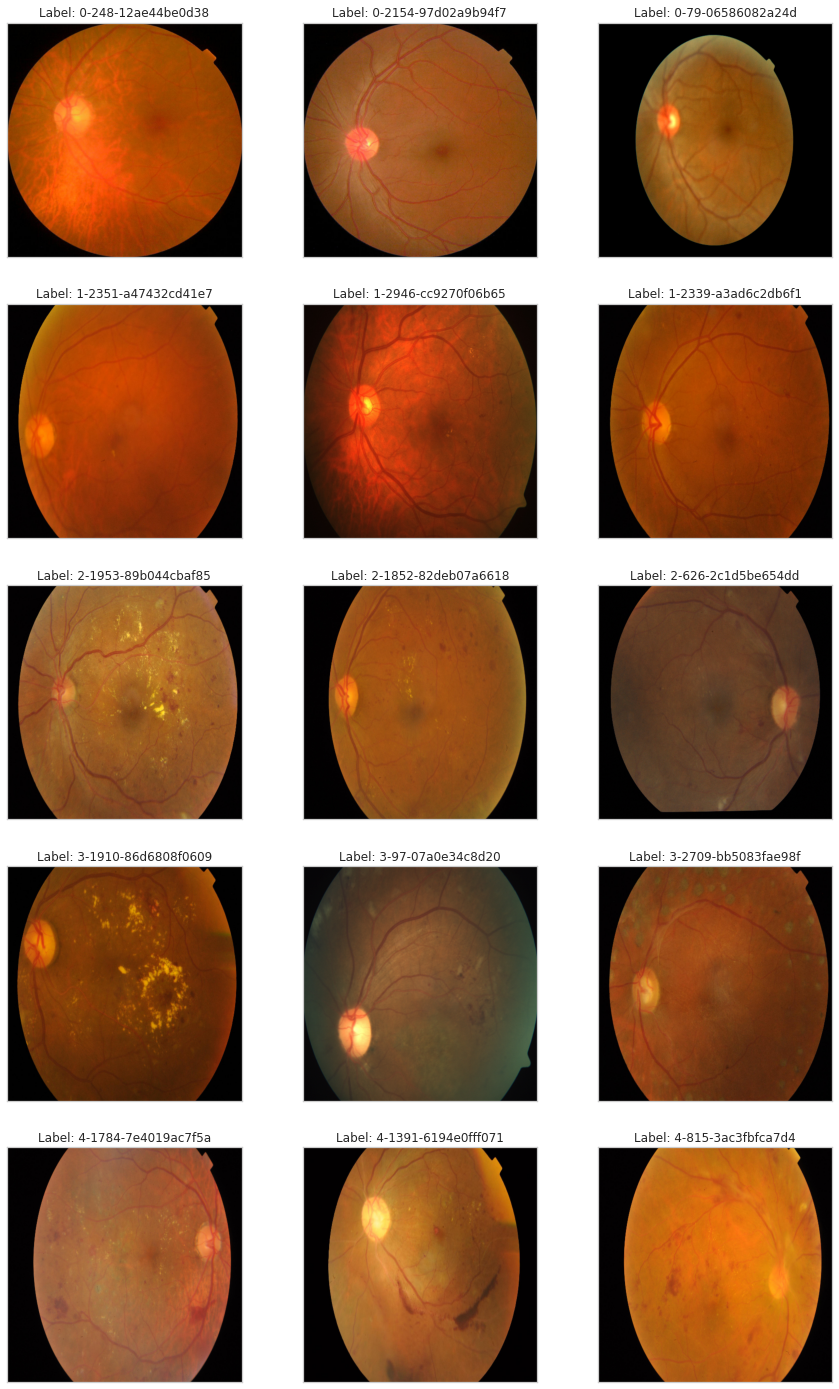

In [9]:
size = 512
rand = 5

fig = plt.figure(figsize=(15,25))
for label in sorted(y.unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == label].sample(3, random_state=rand).iterrows()):
      ax = fig.add_subplot(5, 3, label * 3 + i + 1, xticks=[], yticks=[])
      path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
      image = cv2.imread(path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (size,size))

      plt.imshow(image, cmap = 'gray')
      ax.set_title('Label: %d-%d-%s' % (label, idx, row['id_code']) )

In [10]:
train_df["id_code"] = train_df["id_code"].apply(lambda x: x + ".png")
test_df["id_code"] = test_df["id_code"].apply(lambda x: x + ".png")
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df.head()

id_code diagnosis
0  000c1434d8d7.png         2
1  001639a390f0.png         4
2  0024cdab0c1e.png         1
3  002c21358ce6.png         0
4  005b95c28852.png         0

### **Data Preparation and Model Parameters**

In [11]:
# Model parameters
BATCH_SIZE = 8

WARMUP_EPOCHS = 2
WARMUP_LEARNING_RATE = 1e-3

EPOCHS = 20
LEARNING_RATE = 1e-4

HEIGHT = 512
WIDTH = 512

CHANNEL = 3
N_CLASSES = train_df['diagnosis'].nunique()

ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [12]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 featurewise_center=True,
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,                            
                                 featurewise_std_normalization = True,
                                )

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory= "../input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory= "../input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test_df,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# **Modelling**

## In this project, we employ a CNN model with the ResNet50 architecture.

### Residual learning can be explained with a very simple example. Initially when we learn to ride a bike we make mistakes and we learn. Once we are able to ride the bike, our brain has stopped firing the neurons responsible to learn the skill allowing us to focus on other things involved with riding the bike.

### The ResNet50 architecture does not need to fire all neurons in every epoch. This greatly reduces the training time and improves accuracy. Once a feature is learnt, it does not try to learn it again but rather focuses on learning newer features. A very smart approach that greatly improved model training performance.

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [14]:
def dr_detection_model(input_shape, n_out):
    ip_tensor = Input(shape=input_shape)
    baseModel = ResNet50(weights='imagenet', 
                                       include_top=False,
                                       input_tensor=ip_tensor)
    

    x = GlobalAveragePooling2D()(baseModel.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_op = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(ip_tensor, final_op)
    
    return model

In [15]:
 
model = dr_detection_model(input_shape=(HEIGHT, WIDTH, CHANNEL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

2022-11-06 22:22:26.915165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 22:22:26.916095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 22:22:27.069372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 22:22:27.070279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 22:22:27.071087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
_____________________________

### Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

### The main benefits of transfer learning for machine learning include:

* Removing the need for a large set of labelled training data for every new model.
* Improving the efficiency of machine learning development and deployment for multiple models.
* A more generalised approach to machine problem solving, leveraging different algorithms to solve new challenges.*
* Models can be trained within simulations instead of real-world environments.

### **Train top layers**

In [16]:
training_step_values = train_generator.n//train_generator.batch_size
validation_step_values = valid_generator.n//valid_generator.batch_size

# history_warmup = model.fit(trainX, batch_size=32, epochs=50)

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=training_step_values,
                                     validation_data=valid_generator,
                                     validation_steps=validation_step_values,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

2022-11-06 22:22:36.613899: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2022-11-06 22:22:43.278030: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


366/366 [==============================] - 732s 2s/step - loss: 2.4279 - accuracy: 0.3830 - val_loss: 1.3442 - val_accuracy: 0.4615
Epoch 2/2
366/366 [==============================] - 692s 2s/step - loss: 1.3915 - accuracy: 0.4641 - val_loss: 1.3390 - val_accuracy: 0.4629


### In Top layer training (after 2 eopchs)
##### Training Data Accuracy   : 0.4729             
##### Validation data accuracy : 0.4602

### **Fine-tune the complete model**

In [17]:
for layer in model.layers:
    layer.trainable = True

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
reducing_LRplt = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [early_stop, reducing_LRplt]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

* Total params: 27,794,309
* Trainable params: 27,741,189
* Non-trainable params: 53,120

In [18]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=training_step_values,
                                          validation_data=valid_generator,
                                          validation_steps=validation_step_values,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/20
366/366 [==============================] - 695s 2s/step - loss: 0.8184 - accuracy: 0.7053 - val_loss: 1.5861 - val_accuracy: 0.4602
Epoch 2/20
366/366 [==============================] - 650s 2s/step - loss: 0.6213 - accuracy: 0.7635 - val_loss: 2.6055 - val_accuracy: 0.5343
Epoch 3/20
366/366 [==============================] - 647s 2s/step - loss: 0.5478 - accuracy: 0.7861 - val_loss: 0.8301 - val_accuracy: 0.7527
Epoch 4/20
366/366 [==============================] - 646s 2s/step - loss: 0.5292 - accuracy: 0.7971 - val_loss: 0.6336 - val_accuracy: 0.7555
Epoch 5/20
366/366 [==============================] - 649s 2s/step - loss: 0.5106 - accuracy: 0.8090 - val_loss: 0.5354 - val_accuracy: 0.8049
Epoch 6/20
366/366 [==============================] - 648s 2s/step - loss: 0.4786 - accuracy: 0.8107 - val_loss: 0.5693 - val_accuracy: 0.8049
Epoch 7/20
366/366 [==============================] - 651s 2s/step - loss: 0.4478 - accuracy: 0.8340 - val_loss: 0.4910 - val_accuracy: 0.8187

## Fine Tuning Accuracy (after 13 epochs)
* ### Training Data Accuracy : 0.9617
* ### Validation Data Accuracy : 0.8049

### **Model loss graph**

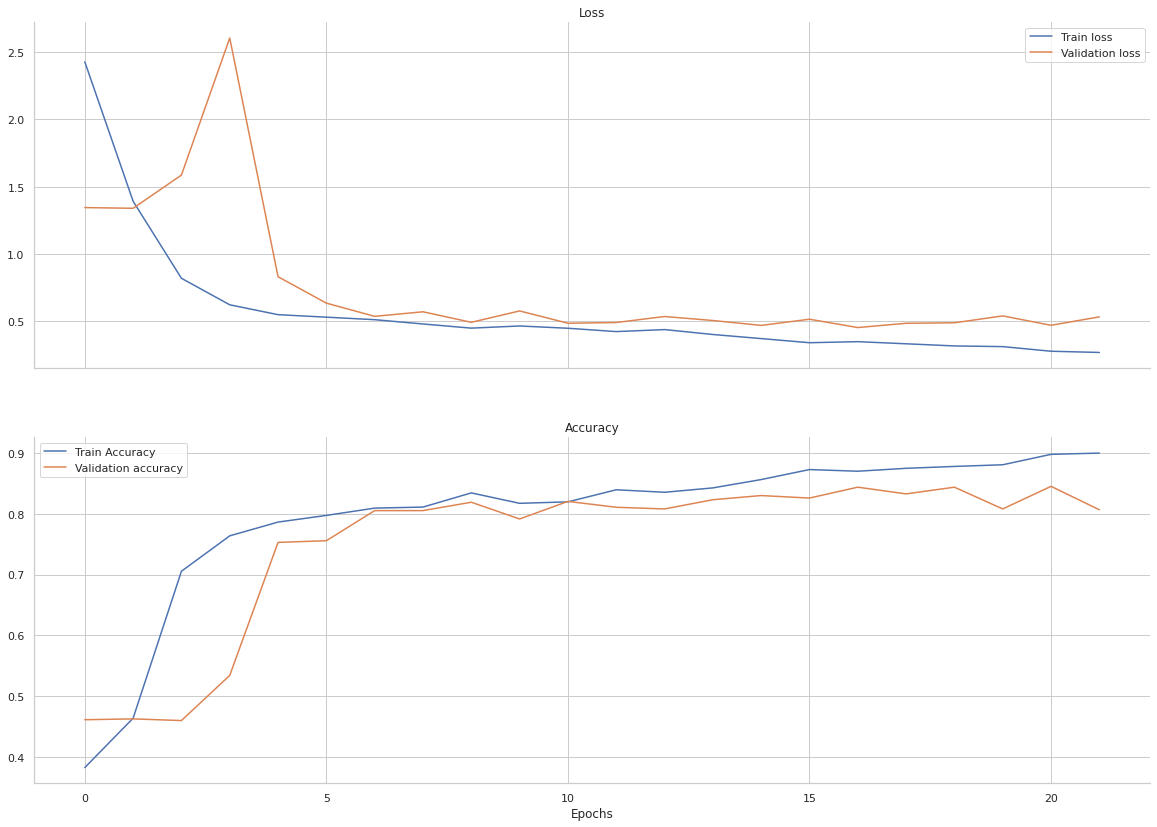

In [19]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'accuracy': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_accuracy': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train Accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

#### The categorical_crossentropy loss on the validation set reaches minimum already after 2 epochs and loss dropped rapidly after 3 epochs continuously approaching towards saturated range of loss till 13 epochs.
#### Accuracy of Validation Dataset increased rapidly after 2 epochs and kept on increasing till it hits the stopping epochs hitted..

In [20]:
model.save("./my_model.h5")

### **Model Evaluation**

### Model evaluation is important to assess the efficacy of a model during initial research phases, and it also plays a role in model monitoring.

In [21]:
cmplt_datagen = ImageDataGenerator(rescale=1./255)
cmplt_generator = cmplt_datagen.flow_from_dataframe(  
        dataframe=train_df,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

complete_step_size = cmplt_generator.n//cmplt_generator.batch_size
train_preds = model.predict_generator(cmplt_generator, steps=complete_step_size)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


### **Confusion Matrix**[](http://)

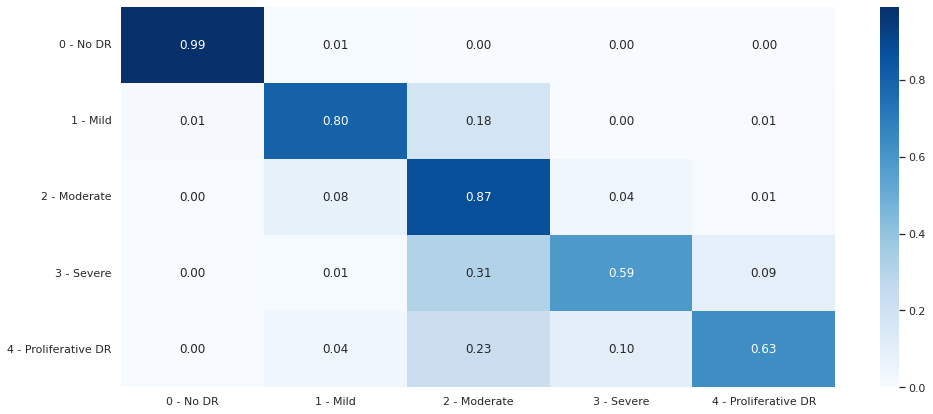

In [22]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_mtx = confusion_matrix(train_df['diagnosis'].astype('int'), train_preds)
cnf_mtx_norm = cnf_mtx.astype('float') / cnf_mtx.sum(axis=1)[:, np.newaxis]
df_cnf_mtx = pd.DataFrame(cnf_mtx_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cnf_mtx, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [23]:
print(classification_report(train_df['diagnosis'].astype('int'), train_preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1805
           1       0.73      0.80      0.76       370
           2       0.82      0.87      0.84       999
           3       0.63      0.59      0.61       193
           4       0.87      0.63      0.73       295

    accuracy                           0.89      3662
   macro avg       0.81      0.78      0.79      3662
weighted avg       0.89      0.89      0.89      3662



### **Quadratic Weighted Kappa**

#### Quadratic Weighted Kappa (QWK) is a statistic to measure the agreement between two annotators. QWK has been widely used as the evaluation measure for various medical imaging problems, where, the class labels have a natural ordering

In [24]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_df['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.934


## **Apply model to test set and output predictions**

In [25]:
test_generator.reset()
test_step_values = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=test_step_values,verbose =1)
test_preds = [np.argmax(pred) for pred in preds]

1928/1928 [==============================] - 114s 59ms/step


In [26]:
img_names = test_generator.filenames
res = pd.DataFrame({'id_code':img_names, 'diagnosis':test_preds})
res['id_code'] = res['id_code'].map(lambda x: str(x)[:-4])
res.to_csv('submission.csv',index=False)
res.head(10)

id_code  diagnosis
0  0005cfc8afb6          2
1  003f0afdcd15          2
2  006efc72b638          3
3  00836aaacf06          2
4  009245722fa4          2
5  009c019a7309          2
6  010d915e229a          3
7  0111b949947e          1
8  01499815e469          3
9  0167076e7089          0

## **Predictions class distribution**

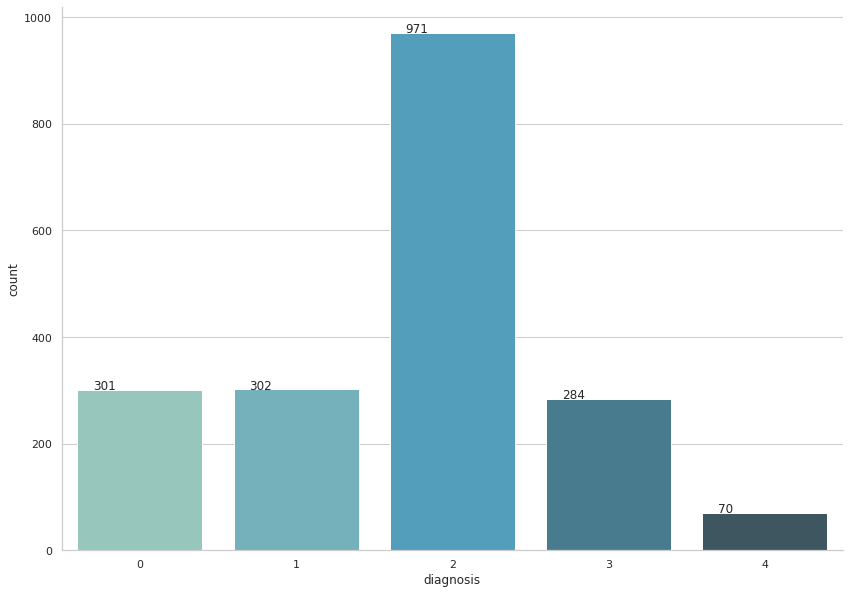

In [27]:
f, ax = plt.subplots(figsize=(14, 10))
ax = sns.countplot(x="diagnosis", data=res, palette="GnBu_d")
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()))
sns.despine()
plt.show()

# **Conclusion**

###  After applying our Model on Test Dataset consisiting 1928 images, Model prediction shows 
#### * Proliferative DR  : 46
#### * Severe DR         : 331   
#### * Moderate DR       : 964
#### * Mild DR           : 292 
#### * No DR             : 295

## Automated screening systems significantly reduce the time required to determine diagnoses, saving effort and costs for ophthalmologists and result in the timely treatment of patients. Automated systems for DR detection play an important role in detecting DR at an early stage. The DR stages are based on the type of lesions that appear on the retina. We can review the most recent automated systems of diabetic retinopathy detection and classification that used deep learning techniques. The common fundus DR datasets that are publicly available have been described, and deep-learning techniques have been briefly explained. Most researchers have used the CNN for the classification and the detection of the DR images due to its efficiency.